# Model 2 – Random Forest ile Kredi Kartı Sahteciliği Tespiti

Bu notebook, temizlenmiş veriyi kullanarak **Random Forest** modeli ile
kredi kartı sahteciliği (fraud) tespiti yapar.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)


## 1. Temizlenmiş Verinin Yüklenmesi


In [2]:
data_path = "data/processed/creditcard_clean.csv"

df = pd.read_csv(data_path)
print("Veri boyutu:", df.shape)
df.head()


Veri boyutu: (283726, 33)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled,Time_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244200,-1.996823
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342584,-1.996823
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.158900,-1.996802
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.139886,-1.996802
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073813,-1.996781


## 2. Hedef Sütun ve Özelliklerin Ayrılması


In [3]:
# Hedef sütun (fraud = 1, normal = 0)
target_col = "Class"   # gerekirse ismi değiştir

# Özellikler (X) ve hedef (y)
X = df.drop(columns=[target_col])
y = df[target_col]

print("Özellik matrisi şekli:", X.shape)
print("Hedef vektörü şekli:", y.shape)


Özellik matrisi şekli: (283726, 32)
Hedef vektörü şekli: (283726,)


## 3. Eğitim ve Test Setlerinin Oluşturulması


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train sınıf dağılımı:\n", y_train.value_counts(normalize=True))
print("y_test  sınıf dağılımı:\n", y_test.value_counts(normalize=True))


X_train: (226980, 32)
X_test : (56746, 32)
y_train sınıf dağılımı:
 Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64
y_test  sınıf dağılımı:
 Class
0    0.998326
1    0.001674
Name: proportion, dtype: float64


## 4. Random Forest Modelinin Eğitilmesi (Model 2)


In [5]:
rf = RandomForestClassifier(
    n_estimators=300,            # Ağaç sayısı
    max_depth=None,             # Maksimum derinlik (None = serbest)
    random_state=42,
    n_jobs=-1,                  # Tüm çekirdekleri kullan
    class_weight="balanced"     # Sınıf dengesizliği için önemli
)

rf.fit(X_train, y_train)

print("Model eğitimi tamamlandı.")


Model eğitimi tamamlandı.


## 5. Tahmin ve Temel Değerlendirme


In [6]:
# Sınıf tahmini
y_pred = rf.predict(X_test)

# Olasılık tahmini (fraud olma olasılığı)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC skoru:", roc_auc)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.69      0.81        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.90     56746
weighted avg       1.00      1.00      1.00     56746

ROC-AUC skoru: 0.9335404494183687


## 6. Karmaşıklık Matrisi (Confusion Matrix)


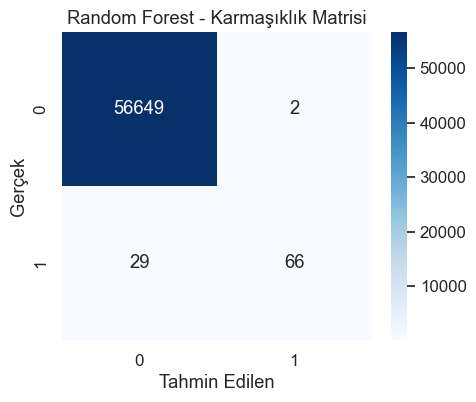

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Random Forest - Karmaşıklık Matrisi")
plt.show()


## 7. ROC Eğrisi


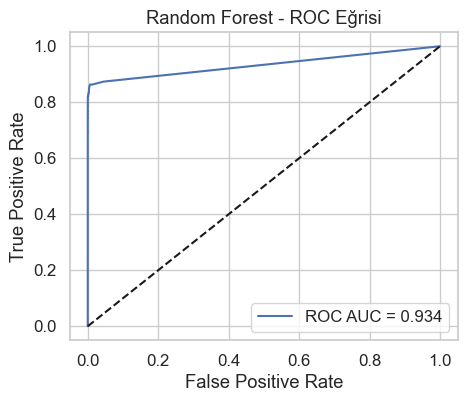

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Eğrisi")
plt.legend()
plt.show()


## 8. Precision-Recall Eğrisi


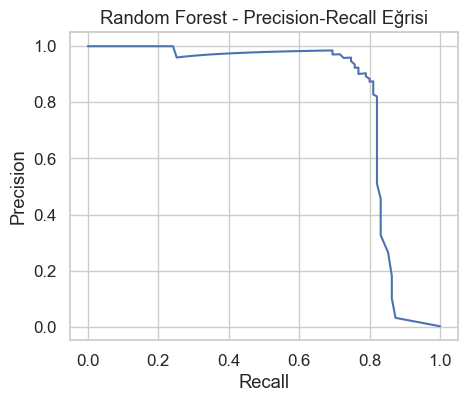

In [9]:
prec, rec, thr = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random Forest - Precision-Recall Eğrisi")
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os


model = RandomForestClassifier(
    n_estimators=120,       
    max_depth=8,           
    min_samples_split=5,   
    min_samples_leaf=5,    
    max_features="sqrt",    
    class_weight="balanced",  
    n_jobs=-1,             
    random_state=42
)

# -----------------------------
# 2) Model eğitimi ve tahminler
# -----------------------------
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# -----------------------------
# 3) Şekil klasörünün oluşturulması
# -----------------------------
os.makedirs("outputs/figures", exist_ok=True)

# -----------------------------
# 4) Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig("outputs/figures/random_forest_confusion.png", dpi=300)
plt.close()

# -----------------------------
# 5) ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}", color="orange")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)  # referans çizgisi
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/figures/random_forest_roc.png", dpi=300)
plt.close()

# -----------------------------
# 6) Precision-Recall Curve
# -----------------------------
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random Forest - Precision-Recall Curve")
plt.tight_layout()
plt.savefig("outputs/figures/random_forest_pr.png", dpi=300)
plt.close()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.81      0.75      0.78        95

    accuracy                           1.00     56746
   macro avg       0.90      0.87      0.89     56746
weighted avg       1.00      1.00      1.00     56746



## 9. Sonuçların Kaydedilmesi (JSON + Rapor)


In [11]:
from pathlib import Path
import json

OUT = Path("outputs/reports")
OUT.mkdir(parents=True, exist_ok=True)

# Classification report sözlüğe dönüştürme
report_dict = classification_report(y_test, y_pred, output_dict=True)

metrics = {
    "roc_auc": roc_auc,
    "classification_report": report_dict
}

json_path = OUT / "random_forest_metrics.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=4)

txt_path = OUT / "random_forest_classification_report.txt"
with open(txt_path, "w", encoding="utf-8") as f:
    f.write(classification_report(y_test, y_pred))

print("Metrikler kaydedildi:\n ", json_path)
print("Sınıflandırma raporu kaydedildi:\n ", txt_path)


Metrikler kaydedildi:
  outputs\reports\random_forest_metrics.json
Sınıflandırma raporu kaydedildi:
  outputs\reports\random_forest_classification_report.txt


In [12]:
import numpy as np
import os

os.makedirs("outputs/reports", exist_ok=True)

np.save("outputs/reports/random_forest_y_test.npy", y_test)
np.save("outputs/reports/random_forest_y_pred.npy", y_pred)
np.save("outputs/reports/random_forest_y_prob.npy", y_prob)

print("Random Forest tahminleri kaydedildi (outputs/reports/...).")


Random Forest tahminleri kaydedildi (outputs/reports/...).


## 10. Özet

- Bu notebook'ta **temizlenmiş veri** kullanılarak **Random Forest (Model 2)** eğitildi.  
- Sonuçlar:
  - ROC-AUC skoru, karmaşıklık matrisi ve precision-recall eğrileri incelendi.
  - Metrikler `outputs/reports/random_forest_metrics.json` dosyasına kaydedildi.
  - Detaylı sınıflandırma sonuçları `random_forest_classification_report.txt` dosyasına yazıldı.

Diğer grup arkadaşların, kendi modellerini (LightGBM, XGBoost, vb.)
aynı adımları izleyerek bu temiz veriyi kullanarak kolayca uygulayabilir.
